Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


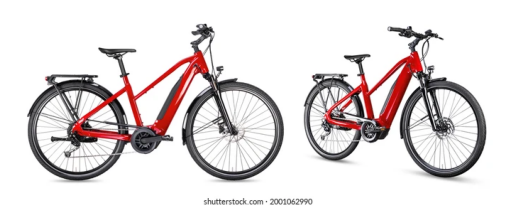

Found 1 candidate regions
Selected region: 0,0,699,280


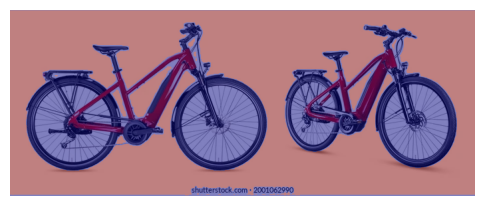

In [6]:
# Imports
from google.colab import drive
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from segment_anything import sam_model_registry, SamPredictor

device = "cuda" if torch.cuda.is_available() else "cpu"

# Mount Drive
drive.mount('/content/drive')

# Paths
sam_checkpoint = "/content/drive/MyDrive/checkpoints/sam_vit_b_01ec64.pth"
image_path = "/content/drive/MyDrive/resources/sample.jpg"

#Load image and SAM
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_pil = Image.fromarray(img_rgb)

sam_model_type = "vit_b"
sam = sam_model_registry[sam_model_type](checkpoint=sam_checkpoint)
sam.to(device)
predictor = SamPredictor(sam)

plt.imshow(img_rgb); plt.axis('off'); plt.show()

# Text prompt
text_prompt = "Red bicycle"

# Contour-based region proposals
gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
blur = cv2.GaussianBlur(gray, (5,5), 0)
_, thresh = cv2.threshold(blur, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

region_boxes = []
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if w*h > 100:  # ignore tiny regions
        region_boxes.append((x, y, w, h))

print(f"Found {len(region_boxes)} candidate regions")

# Simple color heuristic for text-prompt matching
def region_score_by_color(region, keyword):
    avg_color = region.mean(axis=(0,1))  # RGB
    if "red" in keyword:
        return avg_color[0]
    elif "green" in keyword:
        return avg_color[1]
    elif "blue" in keyword:
        return avg_color[2]
    else:
        return region.shape[0]*region.shape[1]  # fallback: largest area

scores = []
for (x, y, w, h) in region_boxes:
    roi = img_rgb[y:y+h, x:x+w]
    scores.append(region_score_by_color(roi, text_prompt))

best_idx = np.argmax(scores)
x, y, w, h = region_boxes[best_idx]
print(f"Selected region: {x},{y},{w},{h}")

# Feed selected region to SAM 2
predictor.set_image(img_rgb)
input_box = np.array([x, y, x+w, y+h])
masks, _, _ = predictor.predict(box=input_box, multimask_output=False)
mask = masks[0]

# Visualize final mask overlay
plt.figure(figsize=(6,6))
plt.imshow(img_rgb)
plt.imshow(mask, alpha=0.5, cmap='jet')
plt.axis('off')
plt.show()
